# Sentiment Analysis of Customer Feedback Using Logistic Regression

In [52]:
!pip install graphviz numpy pandas matplotlib seaborn scikit-learn joblib

DEPRECATION: Loading egg at /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pygame-2.6.0.dev1-py3.12-macosx-10.9-universal2.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [53]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from graphviz import Source
from IPython.display import Image
import joblib

## 1. Load and Combine Data

In [9]:
amazon_file = "dataset/amazon_cells_labelled.txt"
imdb_file = "dataset/imdb_labelled.txt"
yelp_file = "dataset/yelp_labelled.txt"
amazon_data = pd.read_csv(amazon_file, sep='\t', header=None, names=['text', 'label'])
imdb_data = pd.read_csv(imdb_file, sep='\t', header=None, names=['text', 'label'], on_bad_lines='skip')
yelp_data = pd.read_csv(yelp_file, sep='\t', header=None, names=['text', 'label'])

In [10]:
combined_data = pd.concat([amazon_data, imdb_data, yelp_data], ignore_index=True)
combined_data.head()

,text,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [11]:
print(f"Total records: {len(combined_data)}")

Total records: 2748


In [12]:
print(combined_data.isnull().sum())
print(combined_data['label'].value_counts())
print(f"Duplicate rows: {combined_data.duplicated().sum()}")

text     0
label    0
dtype: int64
label
1    1386
0    1362
Name: count, dtype: int64
Duplicate rows: 17


## 2. Data Preprocessing

In [13]:
combined_data = combined_data.drop_duplicates().reset_index(drop=True)

In [14]:
print(f"Duplicate rows: {combined_data.duplicated().sum()}")

Duplicate rows: 0


In [16]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

In [17]:
combined_data['text'] = combined_data['text'].apply(clean_text)
combined_data.head()

,text,label
0,so there is no way for me to plug it in here i...,0
1,good case excellent value,1
2,great for the jawbone,1
3,tied to charger for conversations lasting more...,0
4,the mic is great,1


## 3. Split the Dataset

In [19]:
X_train, X_test, y_train, y_test = train_test_split(combined_data['text'], combined_data['label'], test_size=0.2, random_state=42)

In [20]:
print(f"Training data: {len(X_train)} samples")
print(f"Testing data: {len(X_test)} samples")

Training data: 2184 samples
Testing data: 547 samples


## 4. Text Vectorization

In [22]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [23]:
print(f"Training data shape: {X_train_tfidf.shape}")
print(f"Testing data shape: {X_test_tfidf.shape}")

Training data shape: (2184, 4427)
Testing data shape: (547, 4427)


## 5. Train the Logistic Regression Model

In [25]:
model = LogisticRegression()

In [26]:
model.fit(X_train_tfidf, y_train)

LogisticRegression()

## 6. Accuracy Metric

In [28]:
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.79


In [29]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       270
           1       0.81      0.77      0.79       277

    accuracy                           0.79       547
   macro avg       0.79      0.79      0.79       547
weighted avg       0.79      0.79      0.79       547



In [30]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[220  50]
 [ 64 213]]


## 7. Visualizations

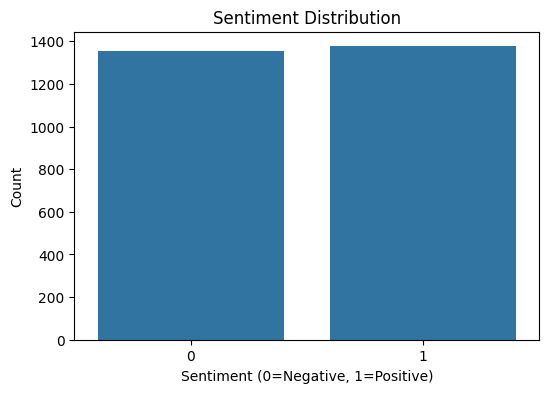

In [33]:
plt.figure(figsize=(6, 4))
sns.countplot(x=combined_data['label'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment (0=Negative, 1=Positive)')
plt.ylabel('Count')
plt.show()

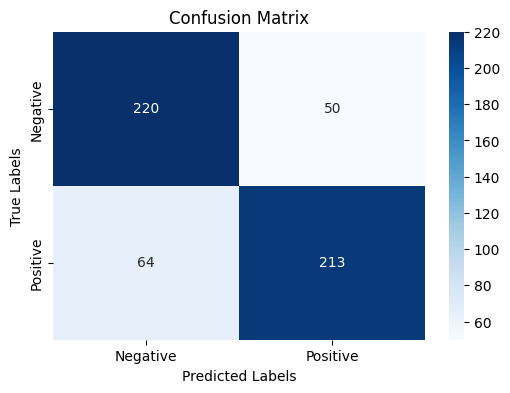

In [34]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

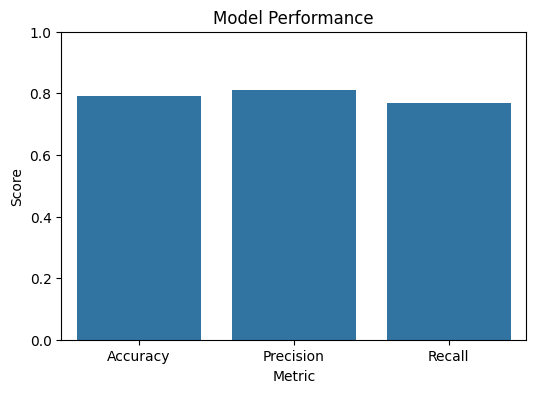

In [36]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
metrics = {'Metric': ['Accuracy', 'Precision', 'Recall'], 'Score': [accuracy, precision, recall]}
metrics_df = pd.DataFrame(metrics)
plt.figure(figsize=(6, 4))
sns.barplot(x='Metric', y='Score', data=metrics_df)
plt.title('Model Performance')
plt.ylim(0, 1)
plt.show()

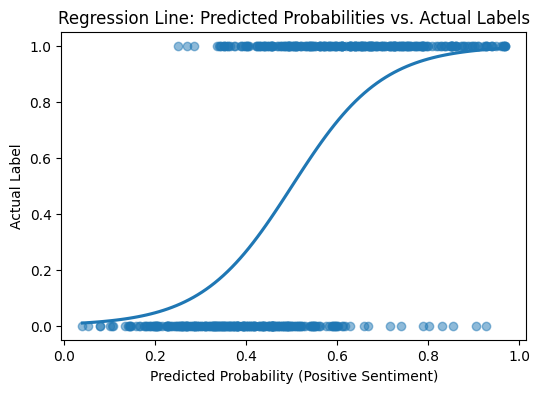

In [39]:
y_prob = model.predict_proba(X_test_tfidf)[:, 1]
plt.figure(figsize=(6, 4))
sns.regplot(x=y_prob, y=y_test, logistic=True, ci=None, scatter_kws={'alpha':0.5})
plt.title('Regression Line: Predicted Probabilities vs. Actual Labels')
plt.xlabel('Predicted Probability (Positive Sentiment)')
plt.ylabel('Actual Label')
plt.show()

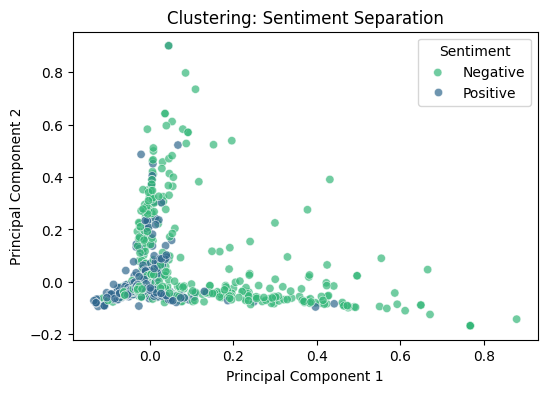

In [41]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
plt.figure(figsize=(6, 4))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, palette='viridis', alpha=0.7)
plt.title('Clustering: Sentiment Separation')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Sentiment', loc='best', labels=['Negative', 'Positive'])
plt.show()

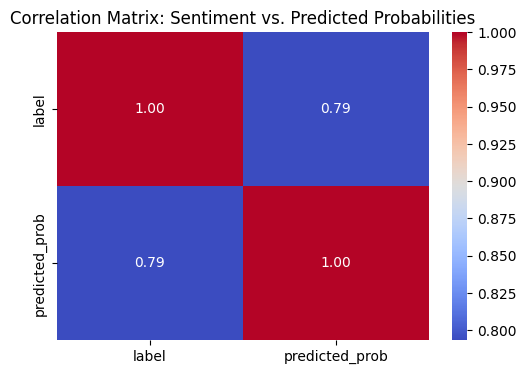

In [43]:
combined_data['predicted_prob'] = model.predict_proba(vectorizer.transform(combined_data['text']))[:, 1]
correlation_matrix = combined_data[['label', 'predicted_prob']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix: Sentiment vs. Predicted Probabilities')
plt.show()

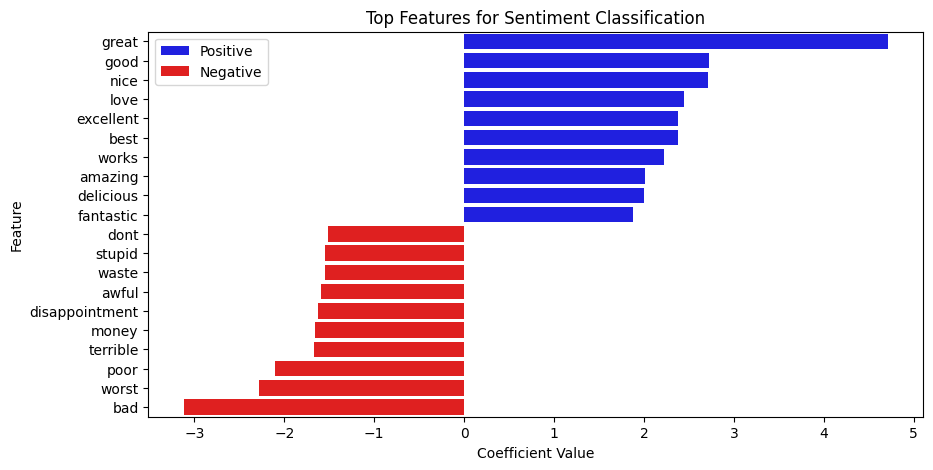

In [42]:
feature_names = vectorizer.get_feature_names_out()
coefficients = model.coef_.flatten()
important_features = pd.DataFrame({'Feature': feature_names,'Coefficient': coefficients}).sort_values(by='Coefficient', ascending=False)
top_positive = important_features.head(10)
top_negative = important_features.tail(10)
plt.figure(figsize=(10, 5))
sns.barplot(x='Coefficient', y='Feature', data=top_positive, color='blue', label='Positive')
sns.barplot(x='Coefficient', y='Feature', data=top_negative, color='red', label='Negative')
plt.title('Top Features for Sentiment Classification')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.legend()
plt.show()

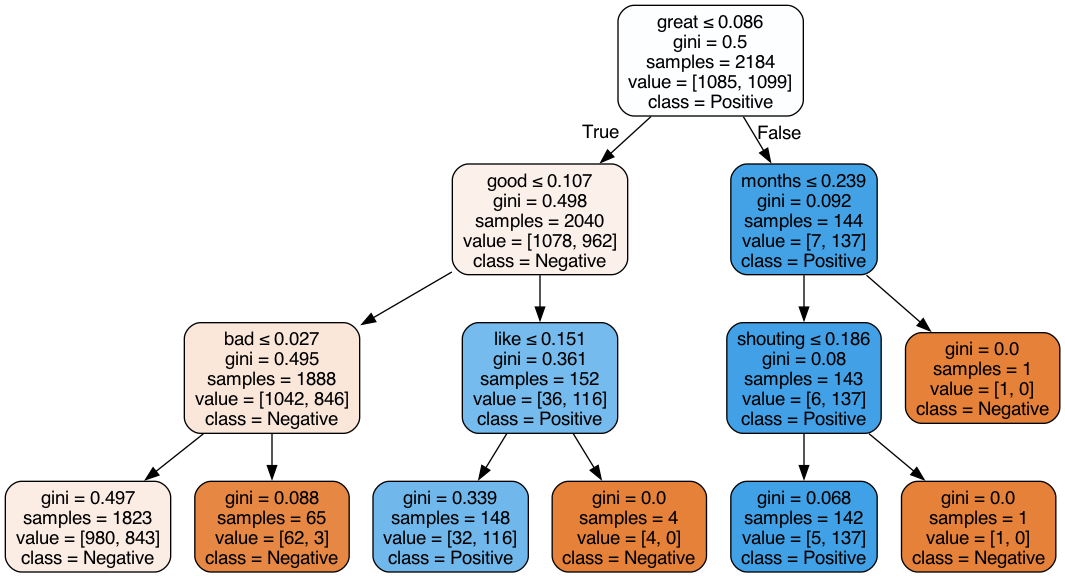

In [48]:
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X_train_tfidf, y_train)
tree_dot = export_graphviz(
    tree_model,
    out_file=None,
    feature_names=vectorizer.get_feature_names_out(),
    class_names=['Negative', 'Positive'],
    filled=True,
    rounded=True,
    special_characters=True
)
graph = Source(tree_dot)
graph.format = "png"
graph.render("decision_tree", cleanup=True)
Image(filename="decision_tree.png")

## 8. User Application

In [49]:
def predict_sentiment(feedback):
    feedback_cleaned = clean_text(feedback)
    feedback_vectorized = vectorizer.transform([feedback_cleaned])
    prediction = model.predict(feedback_vectorized)
    sentiment = "Negative"
    if prediction[0] == 1:
        sentiment = "Positive"
    return sentiment

In [50]:
def sentiment_analysis_interface():
    print("=== Sentiment Analysis Application ===")
    print("Enter a sentence to analyze its sentiment (type 'exit' to quit):")
    while True:
        feedback = input("Enter feedback: ")
        if feedback.lower() == 'exit':
            print("Thank you for using the Sentiment Analysis Application!")
            break
        sentiment = predict_sentiment(feedback)
        print(f"Predicted Sentiment: {sentiment}")

In [51]:
sentiment_analysis_interface()

=== Sentiment Analysis Application ===
Enter a sentence to analyze its sentiment (type 'exit' to quit):
Predicted Sentiment: Positive
Predicted Sentiment: Negative
Predicted Sentiment: Positive
Predicted Sentiment: Positive
Thank you for using the Sentiment Analysis Application!


## 9. Model Save

In [54]:
joblib.dump(model, "sentiment_model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")
print("Model and vectorizer saved successfully!")

Model and vectorizer saved successfully!
